# By Yifeng Luo

In [75]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import confusion_matrix, recall_score, classification_report
import itertools

In [2]:
!ls -a

 .					   data
 ..					   .git
'1. data preprocessing + data exp.ipynb'   .gitignore
'2. clean data.ipynb'			   .ipynb_checkpoints
'3. LogisticRegression.ipynb'		   nedata


In [59]:
training = pd.read_csv('./nedata/training_data.csv')
test = pd.read_csv('./nedata/test_data.csv')
dev = pd.read_csv('./nedata/dev_data.csv')

### extract the text features

And we are using bags-of-words as our word embedding methods

In [60]:
X_train = training.text.values
y_train = training.label.values

X_test = test.text.values
y_test = test.label.values

X_dev = dev.text.values
y_dev = dev.label.values

In [61]:
vectorizer = CountVectorizer()

In [62]:
def fit_ve(vectorizer, train, test, dev):
    vectorizer.fit(train)
    X_train = vectorizer.transform(train)
    X_test = vectorizer.transform(test)
    X_dev = vectorizer.transform(dev)
        
    return X_train, X_test, X_dev

In [63]:
X_train, X_test, X_dev = fit_ve(vectorizer, X_train, X_test, X_dev)

In [64]:
'''
Rows and Columns in our metrics
'''
print('X_train: ', X_train.shape)
print('X_test: ', X_test.shape)
print('X_dev: ',X_dev.shape)

X_train:  (4315, 8673)
X_test:  (539, 8673)
X_dev:  (540, 8673)


In [65]:
'''
Glance to what inside of the metric
The very first row in the training metric

the columns is 8673 which is correct

'''

print(X_train[0].toarray())
print(len(*X_train[0].toarray()))

[[0 0 0 ... 0 0 0]]
8673


# LogisticRegression

In [66]:
'''
Convert X_train, X_test, X_dev to dataframe
'''

X_train = pd.DataFrame(X_train.toarray())
X_test = pd.DataFrame(X_test.toarray())
X_dev = pd.DataFrame(X_dev.toarray())

In [68]:
y_train = pd.DataFrame(y_train)
y_test = pd.DataFrame(y_test)
y_dev = pd.DataFrame(y_dev)

In [72]:
def printing_Kfold_scores(x_train,y_train):
    fold = KFold(n_splits=5,shuffle=False) 

    # Different C parameters
    c_param_range = [0.01,0.1,1,10,100]

    results_table = pd.DataFrame(index = range(len(c_param_range),2), columns = ['C_parameter','Mean recall score'])
    results_table['C_parameter'] = c_param_range

    
    j = 0
    for c_param in c_param_range:
        print('-------------------------------------------')
        print('C parameter: ', c_param)
        print('-------------------------------------------')
        print('')

        recall_accs = []
        for train_index, test_index in fold.split(x_train, y_train):


            
            lr = LogisticRegression(C = c_param, penalty = 'l1', solver='liblinear', max_iter=100000)

            
            lr.fit(x_train.iloc[train_index,:],y_train.iloc[train_index,:].values.ravel())

            # Predict values using the test indices in the training data
            y_pred = lr.predict(x_train.iloc[train_index,:].values)

            # Calculate the recall score and append it to a list for recall scores representing the current c_parameter
            recall_acc = recall_score(y_train.iloc[train_index,:].values,y_pred)
            recall_accs.append(recall_acc)
            print(' recall score = ', recall_acc)

        # The mean value of those recall scores is the metric we want to save and get hold of.
        results_table.iloc[j,results_table.columns.get_loc('Mean recall score')] = np.mean(recall_accs)
        j += 1
        print('')
        print('Mean recall score ', np.mean(recall_accs))
        print('')

    best_c = results_table.loc[results_table['Mean recall score'].astype(float).idxmax()]['C_parameter']
    
    # Finally, we can check which C parameter is the best amongst the chosen.
    print('*********************************************************************************')
    print('Best model to choose from cross validation is with C parameter = ', best_c)
    print('*********************************************************************************')
    
    return best_c

In [73]:
best_c = printing_Kfold_scores(X_train, y_train)

-------------------------------------------
C parameter:  0.01
-------------------------------------------

 recall score =  0.3477941176470588
 recall score =  0.3338192419825073
 recall score =  0.3530701754385965
 recall score =  0.33969185619955977
 recall score =  0.3326007326007326

Mean recall score  0.341395224773691

-------------------------------------------
C parameter:  0.1
-------------------------------------------

 recall score =  0.8294117647058824
 recall score =  0.8185131195335277
 recall score =  0.8369883040935673
 recall score =  0.8195157740278797
 recall score =  0.8241758241758241

Mean recall score  0.8257209573073363

-------------------------------------------
C parameter:  1
-------------------------------------------

 recall score =  0.8985294117647059
 recall score =  0.8899416909620991
 recall score =  0.8830409356725146
 recall score =  0.8870139398385913
 recall score =  0.8989010989010989

Mean recall score  0.891485415427802

---------------------

**The mean_recall for c= 100 is the best so we use c = 100**

In [76]:
def plot_confusion_matrix(cm, classes, title='Confusion Matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=0)
    plt.yticks(tick_marks, classes)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [81]:
lr = LogisticRegression(C = best_c, penalty = 'l1', solver='liblinear')
lr.fit(X_train,y_train.values.ravel())
y_pred = lr.predict(X_test.values)
y_pred

array([0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1,
       1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0,
       1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0,
       0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0,
       1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1,
       0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0,
       1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1,
       0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1,
       1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0,
       0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1,
       1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0,
       1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0,

Recall metric in the testing dataset:  0.8805970149253731


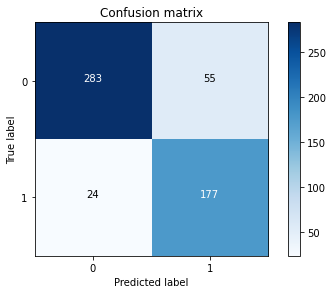

In [82]:
cnf_matrix = confusion_matrix(y_test,y_pred)
np.set_printoptions(precision=2)
print("Recall metric in the testing dataset: ", cnf_matrix[1,1]/(cnf_matrix[1,0]+cnf_matrix[1,1]))
# Plot non-normalized confusion matrix
class_names = [0,1]
plt.figure()
plot_confusion_matrix(cnf_matrix
                      , classes=class_names
                      , title='Confusion matrix')
plt.show()

# Changing the classification threshold

- Initially, you build the classification model and then you predict unseen data using it.
- We previously used the "predict()" method to decided whether a record should belong to "1" or "0".
- There is another method "predict_proba()".
    - his method returns the probabilities for each class. The idea is that by changing the threshold to assign a record to class 1, we can control precision and recall.

Recall metric in the testing dataset:  1.0
Recall metric in the testing dataset:  0.9850746268656716
Recall metric in the testing dataset:  0.9104477611940298
Recall metric in the testing dataset:  0.900497512437811
Recall metric in the testing dataset:  0.3482587064676617
Recall metric in the testing dataset:  0.3482587064676617
Recall metric in the testing dataset:  0.3482587064676617
Recall metric in the testing dataset:  0.3482587064676617
Recall metric in the testing dataset:  0.0


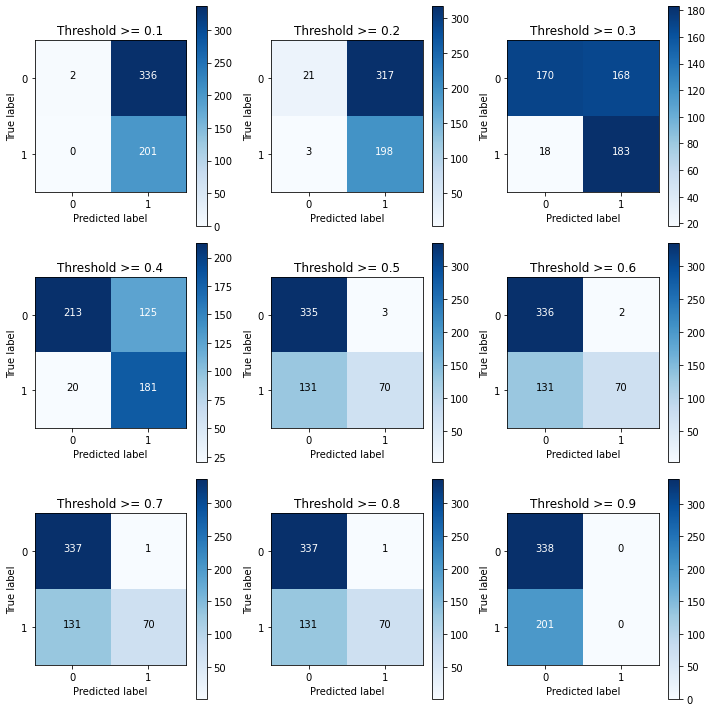

In [84]:
lr = LogisticRegression(C = 0.01, penalty = 'l1', solver='liblinear')
lr.fit(X_train,y_train.values.ravel())
y_pred_proba = lr.predict_proba(X_test.values)

thresholds = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]

plt.figure(figsize=(10,10))

j = 1
for i in thresholds:
    y_test_predictions_high_recall = y_pred_proba[:,1] > i
    
    plt.subplot(3,3,j)
    j += 1
    
    # Compute confusion matrix
    cnf_matrix = confusion_matrix(y_test,y_test_predictions_high_recall)
    np.set_printoptions(precision=2)

    print("Recall metric in the testing dataset: ", cnf_matrix[1,1]/(cnf_matrix[1,0]+cnf_matrix[1,1]))

    # Plot non-normalized confusion matrix
    class_names = [0,1]
    plot_confusion_matrix(cnf_matrix
                          , classes=class_names
                          , title='Threshold >= %s'%i) 

**Threshold >=0.2 we can achieve recall = 0.9850746268656716 in testing dataset**